In [62]:
import numpy as np
import h5py
import tensorflow as tf
import matplotlib.pyplot as plt
import UtilNNDL as util

from keras.models import Sequential
from keras.layers import Dense, Permute
from keras.layers import ConvLSTM2D, Conv2D, MaxPooling2D
from keras.layers import MaxPooling1D, Conv1D
from keras.layers import GRU, LSTM, BatchNormalization
from keras.layers import TimeDistributed
from keras.layers import Flatten, Reshape, Dropout
from keras.utils import to_categorical
from keras.layers import Activation
from keras import regularizers
from UtilNNDL import plot_hist

#folder = '/home/carla/Downloads/project_datasets/project_datasets/'
folder = 'datasets/'
A01T = h5py.File(folder+'A01T_slice.mat','r')
data = np.copy(A01T['image'])
labels = np.copy(A01T['type'])
labels = labels[0,0:data.shape[0]:1]
labels = np.asarray(labels, dtype=np.int32)

a = data[:56]
b = data[57:]
data = np.vstack((a,b))
data = data[:,:22,:]
a = labels[:56]
b = labels[57:]
labels = np.hstack((a,b))
print data.shape

(287, 22, 1000)


In [63]:
data2d_sliced, labels_sliced = util.create_window_data(data, labels, windows=5)
#util.plot_hist(data2d_sliced)
print data2d_sliced.shape, labels_sliced.shape
data2d = data2d_sliced.reshape(data2d_sliced.shape[0], data2d_sliced.shape[2], data2d_sliced.shape[1], 1)
print data2d.shape

#enc = OneHotEncoder()
#enc_labels = enc.fit_transform(labels.reshape(-1,1)).toarray()
enc_labels = to_categorical(labels_sliced-769, num_classes=4)
print(enc_labels.shape)

(1435, 22, 512) (1435,)
(1435, 512, 22, 1)
(1435, 4)


In [64]:
bs, t, n, c = data2d.shape
np.random.seed(42)
shuffle = np.random.choice(bs,bs,replace=False)

#mask = np.ones_like(data)
#mask[[:,:,21:24]] = True
#newdata = data[mask]
#np.delete(mask, :,:,24)
train_samples = bs - 50
train_data = data2d[shuffle[:train_samples],:,:]
train_labels = enc_labels[shuffle[:train_samples]]
test_data = data2d[shuffle[train_samples:],:,:]
test_labels = enc_labels[shuffle[train_samples:]]
print data2d.shape
print train_data.shape
print test_data.shape

(1435, 512, 22, 1)
(1385, 512, 22, 1)
(50, 512, 22, 1)


# TESTING


deepconvnet no regularization

In [65]:
num_filters = 10
model = Sequential()
model.add(Conv2D(num_filters, kernel_size=(num_filters,1), activation='relu', data_format='channels_last', input_shape=(data2d.shape[1], data2d.shape[2], data2d.shape[3])))  
model.add(Conv2D(num_filters, kernel_size=(15,num_filters), activation='relu') ) 
model.add(MaxPooling2D(pool_size=(3,1)))
model.add(Permute((1,3,2)))

model.add(Conv2D(num_filters*2, kernel_size=(10,num_filters), activation='relu')) 
model.add(MaxPooling2D(pool_size=(3,1)))
model.add(Permute((1,3,2)))

model.add(Conv2D(num_filters*4, kernel_size=(10,num_filters*2), activation='relu')) 
model.add(MaxPooling2D(pool_size=(3,1)))
model.add(Permute((1,3,2)))

model.add(Conv2D(num_filters*8, kernel_size=(10,num_filters*4), activation='relu')) 
model.add(MaxPooling2D(pool_size=(3,1)))
model.add(Reshape((num_filters*8,1)))
model.add(LSTM(32, return_sequences=True))
model.add(LSTM(32))
#model.add(Flatten())
model.add(BatchNormalization())
model.add(Dense(4, activation='softmax'))
model.compile(optimizer = 'adam',
             loss = 'categorical_crossentropy',
             metrics=['accuracy'])
model.summary()
hist = model.fit(train_data,train_labels,epochs=15,validation_split=0.25,batch_size=128)
#model.test_on_batch(test_data, test_labels)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_159 (Conv2D)          (None, 503, 22, 10)       110       
_________________________________________________________________
conv2d_160 (Conv2D)          (None, 489, 13, 10)       15010     
_________________________________________________________________
max_pooling2d_126 (MaxPoolin (None, 163, 13, 10)       0         
_________________________________________________________________
permute_95 (Permute)         (None, 163, 10, 13)       0         
_________________________________________________________________
conv2d_161 (Conv2D)          (None, 154, 1, 20)        26020     
_________________________________________________________________
max_pooling2d_127 (MaxPoolin (None, 51, 1, 20)         0         
_________________________________________________________________
permute_96 (Permute)         (None, 51, 20, 1)         0         
__________

KeyboardInterrupt: 

50/50 [==============================] - 0s 845us/step
Test Score: [1.4661457538604736, 0.57999998331069946]


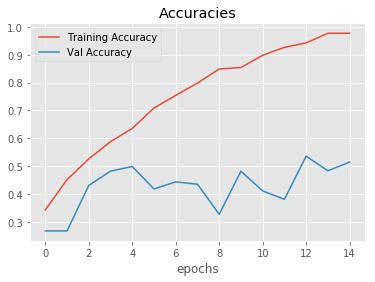

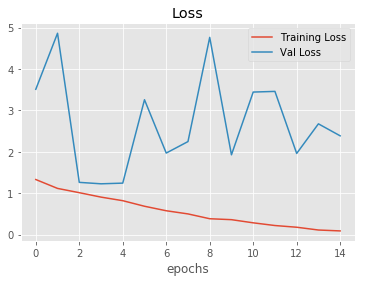

In [25]:
test_score = model.evaluate(test_data, test_labels, batch_size=128)
print "Test Score: {}".format(test_score)
plot_hist([hist.history['acc'],hist.history['val_acc']],['Training Accuracy','Val Accuracy'],title='Accuracies')
plot_hist([hist.history['loss'],hist.history['val_loss']],['Training Loss','Val Loss'],title='Loss')

Trying out:
    * X batchnorm before nonlinearity
    * X regularization
    * dropout 0.5 applied to inputs to conv layers after the first
    * “new tied loss function” for further regularization

In [67]:
num_filters = 10
model = Sequential()
model.add(Conv2D(num_filters, kernel_size=(num_filters,1), activation='relu', data_format='channels_last', input_shape=(data2d.shape[1], data2d.shape[2], data2d.shape[3]), kernel_initializer='glorot_normal', bias_initializer='glorot_normal'))  
model.add(Conv2D(num_filters, kernel_size=(15,num_filters), activation='relu', kernel_initializer='glorot_normal', bias_initializer='glorot_normal') ) 
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(3,1)))
model.add(Permute((1,3,2)))
model.add(Dropout(0.5))

model.add(Conv2D(num_filters*2, kernel_size=(10,num_filters), activation='relu', kernel_initializer='glorot_normal', bias_initializer='glorot_normal')) 
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(3,1)))
model.add(Permute((1,3,2)))
model.add(Dropout(0.5))

model.add(Conv2D(num_filters*4, kernel_size=(10,num_filters*2), activation='relu', kernel_initializer='glorot_normal', bias_initializer='glorot_normal')) 
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(3,1)))
model.add(Permute((1,3,2)))
model.add(Dropout(0.5))

model.add(Conv2D(num_filters*8, kernel_size=(10,num_filters*4), activation='relu', kernel_initializer='glorot_normal', bias_initializer='glorot_normal')) 
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(3,1)))
model.add(Reshape((num_filters*8,1)))
model.add(LSTM(32, return_sequences=True))

model.add(Flatten())
model.add(Dense(4, activation='softmax', kernel_initializer='glorot_normal', bias_initializer='glorot_normal'))
model.compile(optimizer = 'rmsprop',
             loss = 'categorical_crossentropy',
             metrics=['accuracy'])
model.summary()
hist = model.fit(train_data,train_labels,epochs=15,validation_split=0.25,batch_size=32)
#model.test_on_batch(test_data, test_labels)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_169 (Conv2D)          (None, 503, 22, 10)       110       
_________________________________________________________________
conv2d_170 (Conv2D)          (None, 489, 13, 10)       15010     
_________________________________________________________________
batch_normalization_33 (Batc (None, 489, 13, 10)       40        
_________________________________________________________________
max_pooling2d_134 (MaxPoolin (None, 163, 13, 10)       0         
_________________________________________________________________
permute_101 (Permute)        (None, 163, 10, 13)       0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 163, 10, 13)       0         
_________________________________________________________________
conv2d_171 (Conv2D)          (None, 154, 1, 20)        26020     
__________

50/50 [==============================] - 2s 37ms/step
Test Score: [1.3573117256164551, 0.40000000596046448]


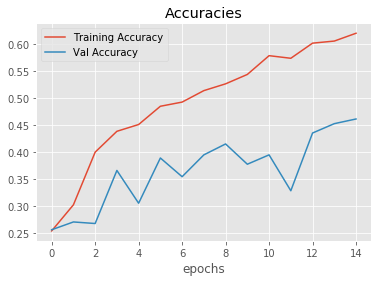

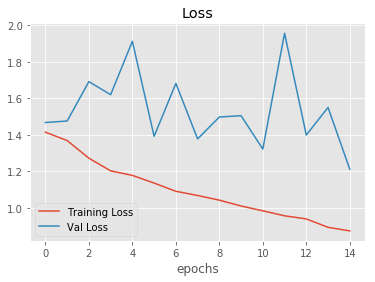

In [68]:
test_score = model.evaluate(test_data, test_labels, batch_size=128)
print "Test Score: {}".format(test_score)
plot_hist([hist.history['acc'],hist.history['val_acc']],['Training Accuracy','Val Accuracy'],title='Accuracies')
plot_hist([hist.history['loss'],hist.history['val_loss']],['Training Loss','Val Loss'],title='Loss')